# Visualise Bi-variate choropleth of PTAL and population density

In [1]:
from scipy.stats.mstats import winsorize
from shapely import Point
# plt.style.use('science')
from shapely import wkt
from shapely.geometry import shape
from scripts_py.scripts import *
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
# Read the JCTSL AI file into a GeoDataFrame
jctsl_ai = pd.read_csv("../data/ai/ai_jctsl.csv")
# Read the CRS information from the separate .prj file
prj_path = "../data/ai/ai_jctsl.csv".replace('.csv', '.prj')
with open(prj_path, 'r') as prj_file:
    crs = prj_file.read()

jctsl_ai['geometry'] = jctsl_ai['geometry'].apply(wkt.loads)
# Set the CRS of the GeoDataFrame
jctsl_ai = gpd.GeoDataFrame(data=jctsl_ai, geometry=jctsl_ai['geometry'], crs=crs)

In [3]:

route_names = ['3',
               '23',
               'AC1',
               'AC2',
               '16',
               '27A',
               '26',
               '1',
               '7',
               '9A',
               'AC3',
               '15',
               '28',
               '32',
               '24',
               '34',
               '1A',
               '3A',
               '10B',
               'AC8',
               'AC7',
               '30',
               'AC5',
               '11',
               '18',
               '6A',
               '4A']
route_dict = {}
for route_name in route_names:
    # Load GeoJSON string from disk
    with open(f'../data/routes/route_{route_name}.geojson', 'r') as f:
        route_geojson = f.read()

    # Convert GeoJSON string back to a LineString object
    route_geojson = shape(json.loads(route_geojson))

    route_dict[route_name] = gpd.GeoSeries([route_geojson], crs='EPSG:32643')

In [4]:
# read bus stops data from disk
bus_stop = pd.read_excel("../data/geo_data/bus_stop/bus_stop_cleaned.xlsx")
bus_stop['geometry'] = [Point(xy) for xy in zip(bus_stop['lon'], bus_stop['lat'])]
bus_stop = gpd.GeoDataFrame(bus_stop, crs="EPSG:4326", geometry='geometry')

In [5]:
# Applying Winsorizing to the 'pop_density_per_sq_km' column
# Setting limits for winsorizing at 5th and 95th percentiles
jctsl_ai['population_density'] = winsorize(jctsl_ai['pop_density_per_sq_km'], limits=[0.05, 0.05])

In [6]:
# Categorizing the 'population_density' into quartiles
jctsl_ai['pop_density_cat'] = pd.qcut(jctsl_ai['population_density'], 2, labels=["A", "B", ])

category A: min:2161.559325661986, max:4127.213848731749 
category B: min:4349.745063944651, max:19545.989565950003 


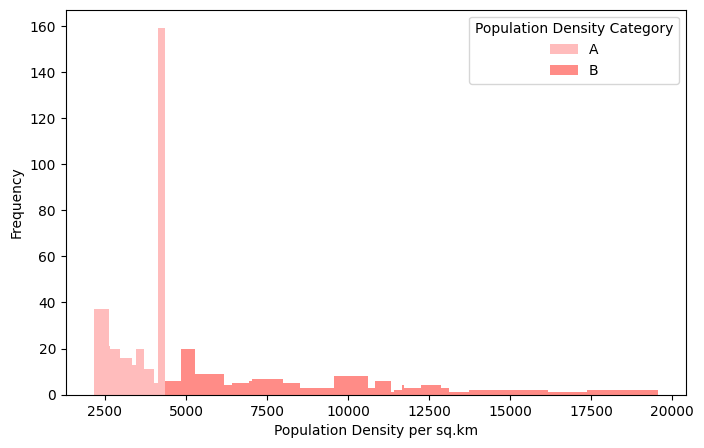

In [37]:
# Create a histogram with colored bars and specified bin edges
fig, ax = plt.subplots(figsize=(8, 5))
# Set up color mapping for categories
colors = {'A': '#FFABAB', 'B': '#FF6F69'}
# Extract bin edges from the data
bin_edges = sorted(jctsl_ai['population_density'])

# Plot histograms with specified bin edges
for category, color in colors.items():
    subset_data = jctsl_ai[jctsl_ai['pop_density_cat'] == category]['population_density']
    ax.hist(subset_data, bins=bin_edges, alpha=0.8, label=category, color=color)
    print(f"category {category}: min:{subset_data.min()}, max:{subset_data.max()} ")

ax.set_xlabel('Population Density per sq.km')
ax.set_ylabel('Frequency')
ax.legend(title='Population Density Category')

plt.show()

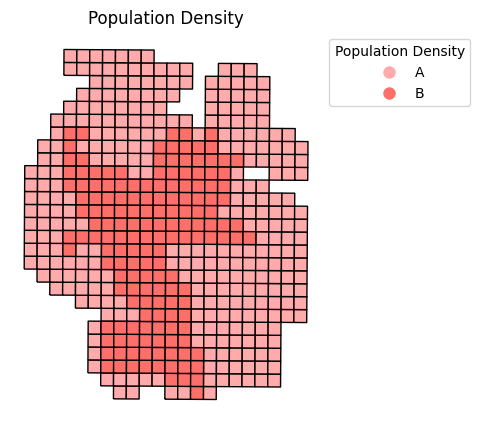

In [8]:
# Plotting the choropleth map
fig, ax = plt.subplots(figsize=(5, 5))

# Define specific colors for each category
colors = {'A': '#FFABAB', 'B': '#FF6F69'}
# Plot each category separately
for category, color in colors.items():
    subset = jctsl_ai[jctsl_ai['pop_density_cat'] == category]
    subset.plot(ax=ax, color=color, label=category, edgecolor='black')
# Create a custom legend using the specified colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                 for label, color in colors.items()]
ax.legend(handles=legend_labels, title='Population Density', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Population Density')
ax.set_axis_off()

plt.show()

In [9]:
# Categorizing the 'accessibility_index' into quartiles
jctsl_ai['accessibility_cat'] = pd.qcut(jctsl_ai['accessibility_index'], 3, labels=["1", "2", "3"])

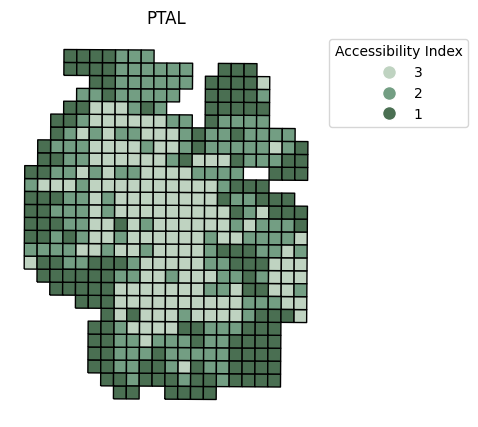

In [10]:
# Plotting the choropleth map
fig, ax = plt.subplots(figsize=(5, 5))

# Define specific colors for each category
colors = {'3': '#BFD3C1', '2': '#739E83', '1': '#4A6F52'}

# Plot each category separately
for category, color in colors.items():
    subset = jctsl_ai[jctsl_ai['accessibility_cat'] == category]
    subset.plot(ax=ax, color=color, label=category, edgecolor='black')

# Create a custom legend using the specified colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                 for label, color in colors.items()]
ax.legend(handles=legend_labels, title='Accessibility Index', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('PTAL')
ax.set_axis_off()

plt.show()

category 3: min:0.766609881969359, max:3.025210085203023 
category 2: min:0.3726708078469195, max:0.7653061232767597 
category 1: min:0.0840179239814317, max:0.3722084371180168 


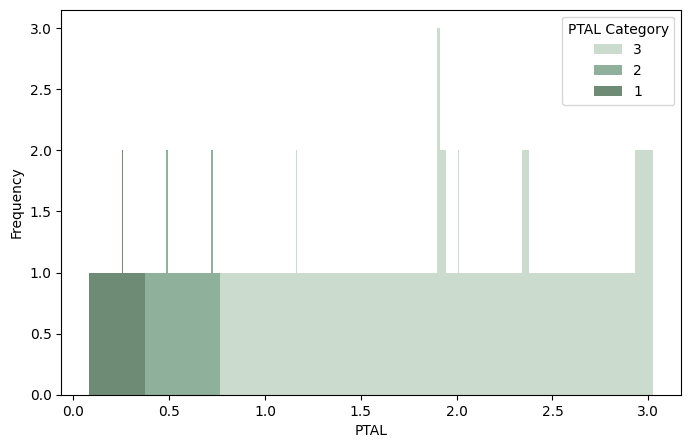

In [36]:
# Create a histogram with colored bars and specified bin edges
fig, ax = plt.subplots(figsize=(8, 5))
# Set up color mapping for categories
colors =  {'3': '#BFD3C1', '2': '#739E83', '1': '#4A6F52'}
# Extract bin edges from the data
bin_edges = sorted(jctsl_ai['accessibility_index'])

# Plot histograms with specified bin edges
for category, color in colors.items():
    subset_data = jctsl_ai[jctsl_ai['accessibility_cat'] == category]['accessibility_index']
    print(f"category {category}: min:{subset_data.min()}, max:{subset_data.max()} ")
    ax.hist(subset_data, bins=bin_edges, alpha=0.8, label=category, color=color)

ax.set_xlabel('PTAL')
ax.set_ylabel('Frequency')
ax.legend(title='PTAL Category')

plt.show()

In [11]:
# Create a new column that combines both categories for color mapping
jctsl_ai['bivariate_cat'] = jctsl_ai['accessibility_cat'].astype(str) + jctsl_ai['pop_density_cat'].astype(str)

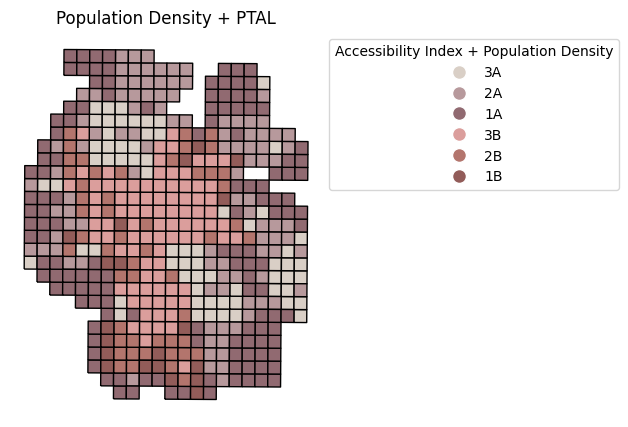

In [12]:
# Plotting the choropleth map
fig, ax = plt.subplots(figsize=(5, 5))

# Define specific colors for each category
colors = {'3A': '#D9CFC6',
          '2A': '#B7999C',
          '1A': '#916A71',
          '3B': '#DB9E9C',
          '2B': '#B3756D',
          '1B': '#925C59'}

# Plot each category separately
for category, color in colors.items():
    subset = jctsl_ai[jctsl_ai['bivariate_cat'] == category]
    subset.plot(ax=ax, color=color, label=category, edgecolor='black')

# Add legend and title
# ax.legend(title='Population Category')
# Create a custom legend using the specified colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                 for label, color in colors.items()]
ax.legend(handles=legend_labels, title='Accessibility Index + Population Density', loc='upper left',
          bbox_to_anchor=(1, 1))
ax.set_title('Population Density + PTAL')
ax.set_axis_off()

plt.show()

In [13]:
stops_to_plot = {}
busy_bus_stops = ['SANGANER THANA', 'AJMERI GATE', 'CHANDPOLE', 'RIDHI SIDHI', 'DADI KA PHATAK']
stops_to_plot['busy bus stops'] = bus_stop[bus_stop.sap_name.isin(busy_bus_stops)]

In [14]:
industrial_area = ['JHOTWARA', '22 GODAM', 'MANSAROWER METRO', 'MALVIYA NAGAR', 'VKI NO. 1', 'KUMBHA MARG']
stops_to_plot['industrial_area'] = bus_stop[bus_stop.sap_name.isin(industrial_area)]

In [15]:
inter_city_terminals = ['SINDHI CAMP', 'TRANSPORT NGR', 'RAMGARH MODE', 'VAISHALI NAGAR', 'SHASTRI NAGAR', 'VIDHYADHAR NAGAR']
stops_to_plot['inter_city_terminals'] = bus_stop[bus_stop.sap_name.isin(inter_city_terminals)]

In [33]:
selected_routes = ['3A']
routes_to_plot = dict(filter(lambda item: item[0] in selected_routes, route_dict.items()))

selected_stops = ['busy bus stops', 'industrial_area', 'inter_city_terminals']
stops_to_plot_selected = dict(filter(lambda item: item[0] in selected_stops, stops_to_plot.items()))

C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\scripts_py\scripts.py:518: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(labels=legend_labels, loc='lower right')


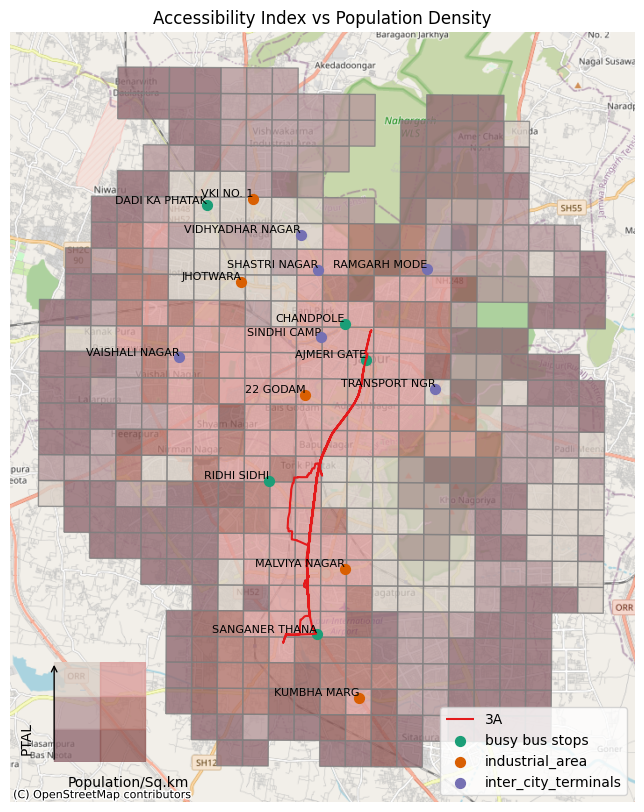

In [34]:
plot_bivariate_choropleth(jctsl_ai, route=routes_to_plot, plot_stops=stops_to_plot_selected)

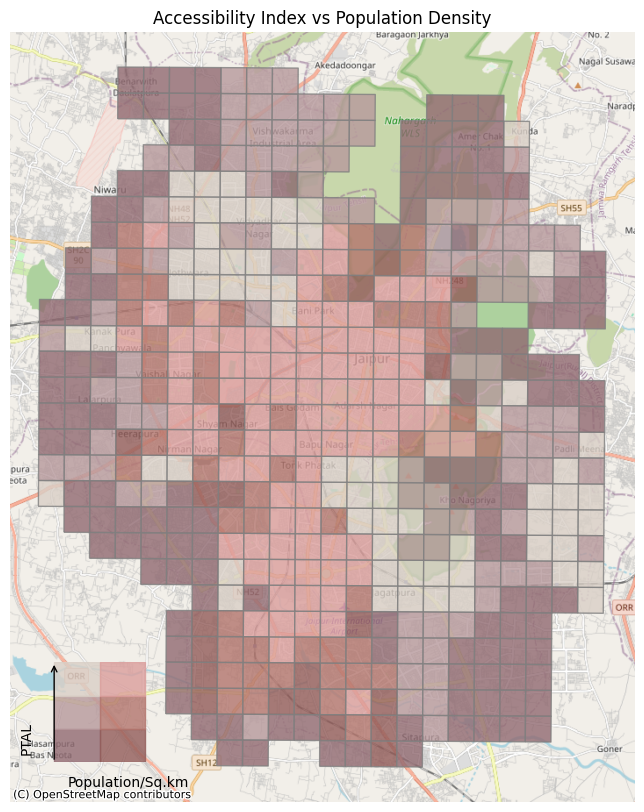

In [18]:
plot_bivariate_choropleth(jctsl_ai, )

In [19]:
indicator = ['1B']
poor_accessibility = jctsl_ai[jctsl_ai.bivariate_cat.isin(indicator)]

In [20]:
plot_stops = list(poor_accessibility.sap_name.unique())
stops_to_plot['nearest stops'] = bus_stop[bus_stop.sap_name.isin(plot_stops)]

In [21]:
selected_routes = ['32']
selected_stops = ['nearest stops', 'industrial_area']
routes_to_plot = dict(filter(lambda item: item[0] in selected_routes, route_dict.items()))
stops_to_plot_1b = dict(filter(lambda item: item[0] in selected_stops, stops_to_plot.items()))

C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothi

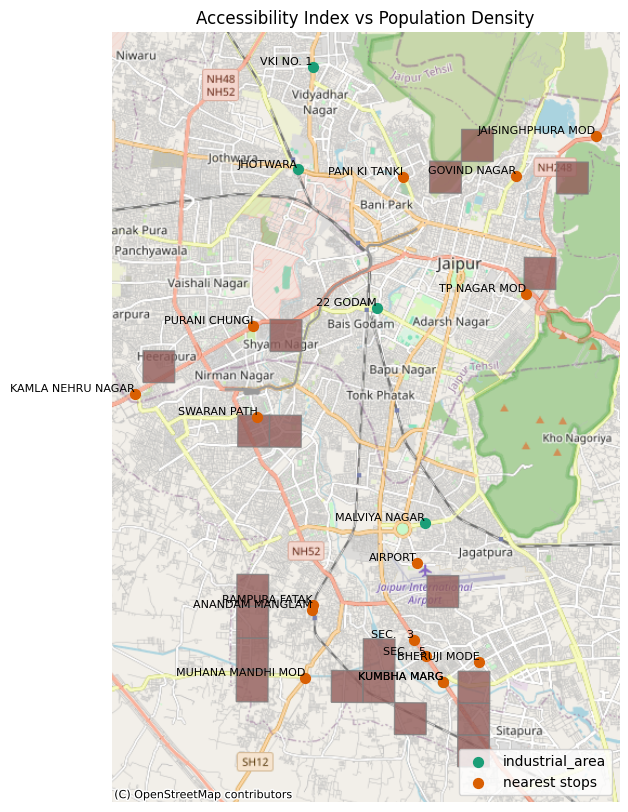

In [22]:
plot_bivariate_choropleth(poor_accessibility, plot_stops=stops_to_plot_1b, route=None, color_legends=False)

In [23]:
indicator = ['2B']
poor_accessibility = jctsl_ai[jctsl_ai.bivariate_cat.isin(indicator)]

In [24]:
busy_bus_stops = list(poor_accessibility.sap_name.unique())
stops_to_plot['nearest stops'] = bus_stop[bus_stop.sap_name.isin(busy_bus_stops)]

In [25]:
selected_routes = ['3', '1', '32', '34', '26']

routes_to_plot = dict(filter(lambda item: item[0] in selected_routes, route_dict.items()))

selected_stops = ['nearest stops']
stops_to_plot_2b = dict(filter(lambda item: item[0] in selected_stops, stops_to_plot.items()))

C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\P70087882\PycharmProjects\JCTSL-PTAL\venv\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothi

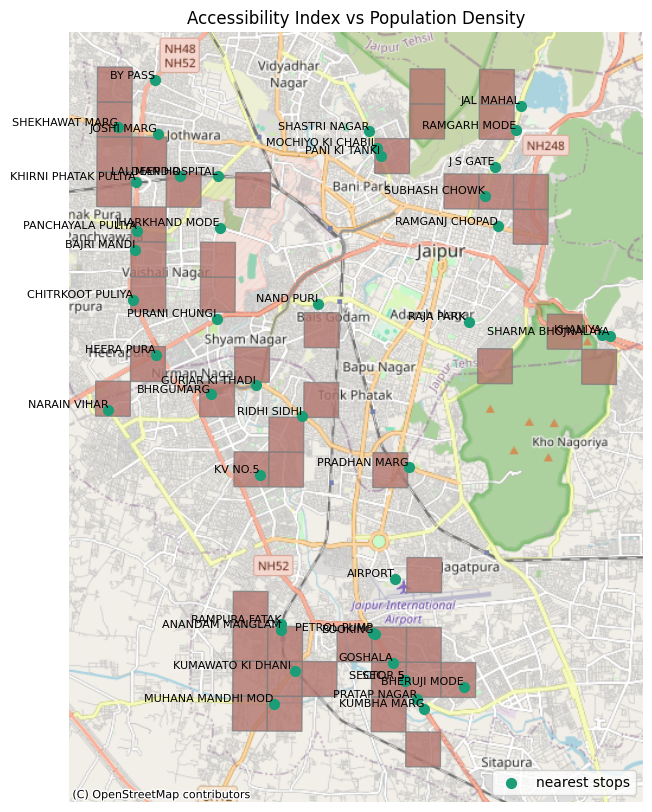

In [26]:
plot_bivariate_choropleth(poor_accessibility, plot_stops=stops_to_plot_2b, route=None, color_legends=False)

In [38]:
# store data to a csv file
jctsl_ai.to_csv("../data/ai/ai_jctsl_cat.csv", index=False, encoding='utf-8', header=True)

# Write the CRS information to a separate file
with open("../data/ai/ai_jctsl_cat.csv".replace('.csv', '.prj'), 'w') as prj_file:
    prj_file.write(jctsl_ai.crs.to_wkt())

In [39]:
jctsl_ai.columns

Index(['geometry', 'POI', 'address', 'node', 'nearest_sap', 'destination',
       'sap_name', 'routes', 'walking_distance', 'WT', 'service_frequency',
       'AWT', 'TAT', 'EDF', 'weighing_factor', 'accessibility_index',
       'pop_density_per_sq_km', 'ZONE_NAME', 'WARD_NO', 'population_density',
       'pop_density_cat', 'accessibility_cat', 'bivariate_cat'],
      dtype='object')